# Benchmarking RDF against MDAnalysis
Below, we show a benchmark of  `freud.density.RDF` and `MDAnalysis.analysis.rdf.InterRDF`. The algorithms in both packages are efficient and rely on parallelized C or C++ code. This benchmark was run on an Intel(R) Core(TM) i7-10750H CPU @ 2.60GHz.

In [1]:
import multiprocessing as mp
import timeit

import freud
import gsd
import matplotlib.pyplot as plt
import MDAnalysis
import MDAnalysis.analysis.rdf
import numpy as np
from tqdm import tqdm

In [2]:
trajectory_filename = "data/rdf_benchmark.gsd"
r_max = 5
r_min = 0.1
nbins = 75

In [3]:
trajectory = MDAnalysis.coordinates.GSD.GSDReader(trajectory_filename)
topology = MDAnalysis.core.topology.Topology(n_atoms=trajectory[0].n_atoms)
u = MDAnalysis.Universe(topology, trajectory_filename, dt=1.0)

rdf = MDAnalysis.analysis.rdf.InterRDF(
    g1=u.atoms, g2=u.atoms, nbins=nbins, range=(r_min, r_max)
).run()

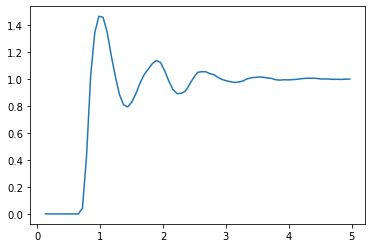

In [4]:
plt.plot(rdf.results.bins, rdf.results.rdf)
plt.show()

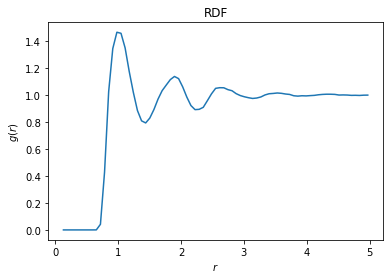

In [5]:
freud_rdf = freud.density.RDF(bins=nbins, r_max=r_max, r_min=r_min)
for frame in trajectory:
    freud_rdf.compute(system=frame, reset=False)
freud_rdf.plot();

## Timing Functions

In [6]:
def time_statement(stmt, repeat=3, number=1, **kwargs):
    timer = timeit.Timer(stmt=stmt, globals=kwargs)
    times = timer.repeat(repeat, number)
    return np.mean(times), np.std(times)

In [7]:
def time_mdanalysis_rdf(trajectory_filename, r_max, r_min, nbins):
    trajectory = MDAnalysis.coordinates.GSD.GSDReader(trajectory_filename)
    frame = trajectory[0]
    topology = MDAnalysis.core.topology.Topology(n_atoms=frame.n_atoms)
    u = MDAnalysis.Universe(topology, trajectory_filename, dt=1.0)
    code = """rdf = MDAnalysis.analysis.rdf.InterRDF(g1=u.atoms, g2=u.atoms, nbins=nbins, range=(r_min, r_max)).run()"""
    return time_statement(
        code, MDAnalysis=MDAnalysis, u=u, r_max=r_max, r_min=r_min, nbins=nbins
    )

In [8]:
def time_freud_rdf(trajectory_filename, r_max, r_min, nbins):
    trajectory = MDAnalysis.coordinates.GSD.GSDReader(trajectory_filename)
    code = """
rdf = freud.density.RDF(bins=nbins, r_max=r_max, r_min=r_min)
for frame in trajectory:
    rdf.compute(system=frame, reset=False)"""
    return time_statement(
        code, freud=freud, trajectory=trajectory, r_max=r_max, r_min=r_min, nbins=nbins
    )

In [9]:
# Test timing functions
params = dict(
    trajectory_filename=trajectory_filename, r_max=r_max, r_min=r_min, nbins=nbins
)


def system_size(trajectory_filename, **kwargs):
    with gsd.hoomd.open(params["trajectory_filename"], "rb") as trajectory:
        return {
            "frames": len(trajectory),
            "particles": len(trajectory[0].particles.position),
        }


print(system_size(**params))
mdanalysis_rdf_runtime = time_mdanalysis_rdf(**params)
print("MDAnalysis:", mdanalysis_rdf_runtime)
freud_rdf_runtime = time_freud_rdf(**params)
print("freud:", freud_rdf_runtime)

{'frames': 5, 'particles': 15625}
MDAnalysis: (7.900110933328203, 0.052645368547175324)
freud: (6.764306033330892, 0.5441674394912741)


## Perform Measurements

In [10]:
def measure_runtime_scaling_r_max(r_maxes, **params):
    result_times = []
    for r_max in tqdm(r_maxes):
        params.update(dict(r_max=r_max))
        freud.parallel.set_num_threads(1)
        freud_single = time_freud_rdf(**params)
        freud.parallel.set_num_threads(0)
        result_times.append(
            (time_mdanalysis_rdf(**params), freud_single, time_freud_rdf(**params))
        )
    return np.asarray(result_times)

In [11]:
def plot_result_times(result_times, r_maxes, frames, particles):
    plt.figure(figsize=(6, 4), dpi=200)
    plt.errorbar(
        r_maxes,
        result_times[:, 0, 0],
        result_times[:, 0, 1],
        label=f"MDAnalysis v{MDAnalysis.__version__} analysis.rdf.InterRDF",
    )
    plt.errorbar(
        r_maxes,
        result_times[:, 1, 0],
        result_times[:, 1, 1],
        label=f"freud v{freud.__version__} density.RDF, 1 thread",
    )
    plt.errorbar(
        r_maxes,
        result_times[:, 2, 0],
        result_times[:, 2, 1],
        label=f"freud v{freud.__version__} density.RDF, {mp.cpu_count()} threads",
    )
    plt.title(fr"RDF for {frames} frames, {particles} particles")
    plt.xlabel(r"RDF $r_{{max}}$")
    plt.ylabel(r"Average Runtime (s)")
    plt.yscale("log")
    plt.legend()
    plt.show()

In [12]:
r_maxes = [0.2, 0.3, 0.5, 1, 2, 3]

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:51<00:00,  8.57s/it]


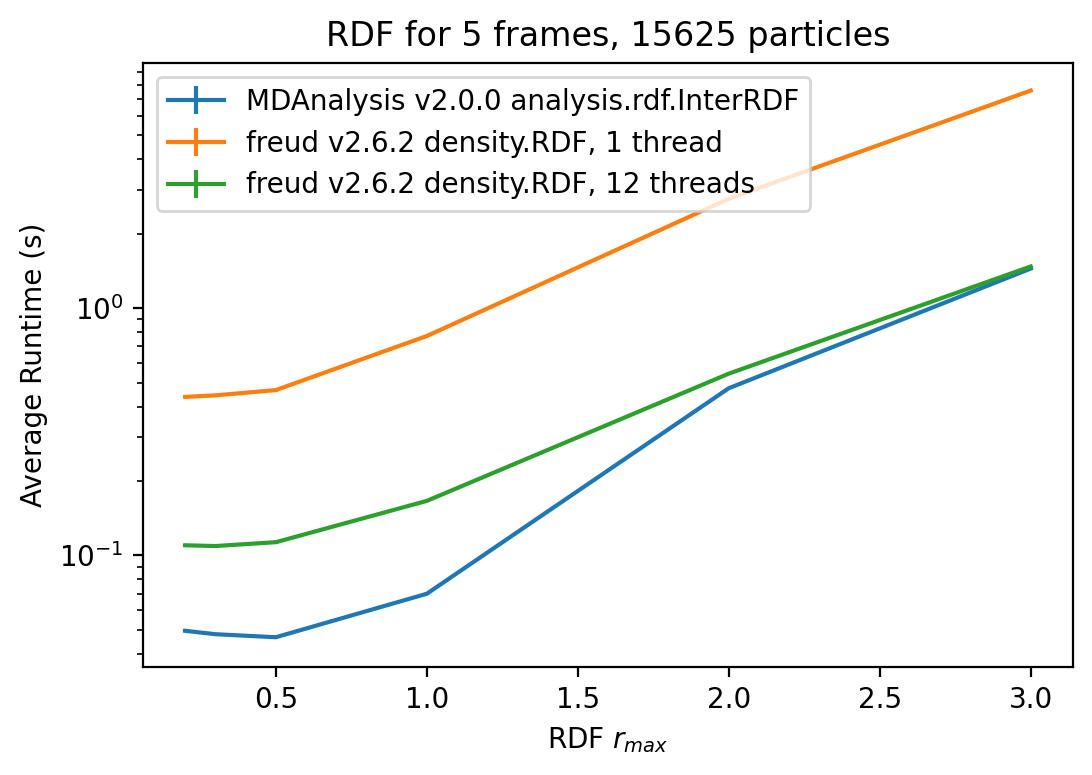

In [13]:
result_times = measure_runtime_scaling_r_max(r_maxes, **params)
plot_result_times(result_times, r_maxes, **system_size(params["trajectory_filename"]))